In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy
import scipy.sparse as sp
from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_toy_mesh
from scipy.integrate import solve_ivp
from solver import get_n_element_operators
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
import imageio_ffmpeg

In [ ]:
plt.rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()

## Rotating Hill

In [2]:
x_0, y_0 = -0.75, -0.25
sigma = 0.1

# JK: Change from np.pi*t/2 to 2πt
def get_hill_center(t, x_0 = x_0, y_0 = y_0):
    x_t = x_0 * np.cos(2 * np.pi*t) + y_0 * np.sin(2 * np.pi*t)
    y_t = -x_0 * np.sin(2 * np.pi*t) + y_0 * np.cos(2 * np.pi*t)
    return x_t, y_t

def u_exact_hill(x, y, t, sigma = sigma):
    x_center_t, y_center_t = get_hill_center(t)
    return np.exp(-((x - x_center_t)**2 + (y - y_center_t)**2)/(2*sigma**2))

def f_rhs_hill(x, y, t, sigma = sigma):
    return 0

def u_exact_hill_dt(x, y, t, sigma=sigma):
    """
    Time derivative ∂_t u_exact_hill(x,y,t).
    u(x,y,t) = exp(-((x-xc)^2 + (y-yc)^2)/(2*sigma^2)),
    center (xc,yc) rotates with angular speed ω = π/2:
      xc' = ω * yc,   yc' = -ω * xc
    ∂_t u = u * [ (x-xc) xc' + (y-yc) yc' ] / sigma^2
    """
    xc, yc = get_hill_center(t)
    omega = 2 * np.pi
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)

def advection_velocity_field(x, y):
    return (2 * np.pi * y, -2 * np.pi * x)

def get_boundary_normal(x, y):
    norm = np.sqrt(x**2 + y**2)
    return x / norm, y / norm

t_array = np.linspace(0, 10, 1000)
x_center_t, y_center_t = get_hill_center(t_array)

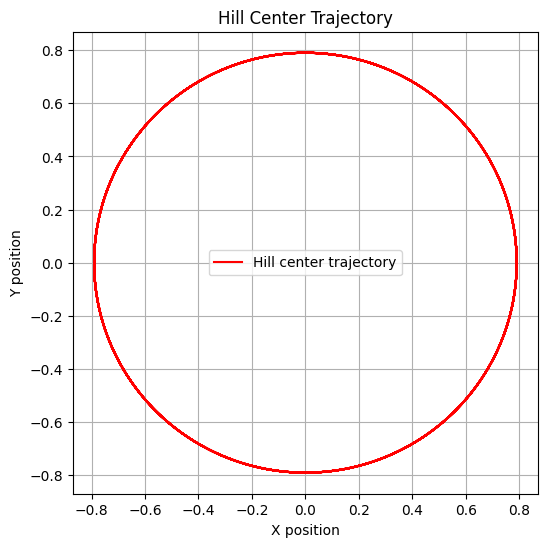

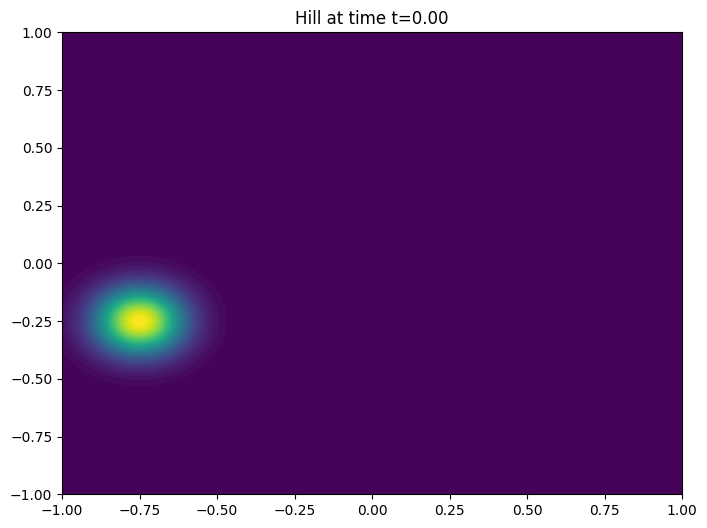

In [3]:
# Show hill center
plt.figure(figsize=(6,6))
plt.plot(x_center_t, y_center_t, 'r-', label='Hill center trajectory')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Hill Center Trajectory')
plt.legend()
plt.grid()
plt.show()

# Show entire hill, just use square domain for simplicity

# x = np.linspace(-1, 1, 200)
# y = np.linspace(-1, 1, 200)
# X, Y = np.meshgrid(x, y)
# t_sample = 10.0
# U = u_exact_hill(X, Y, t_sample)
# plt.figure(figsize=(8,6))
# plt.contourf(X, Y, U, levels=50, cmap='viridis')

# Show animation


fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
t_array = np.linspace(0, 1, 100)

def animate_hill(t):  # Changed parameter name from t_array to t
    U = u_exact_hill(X, Y, t)
    ax.clear()
    cont = ax.contourf(X, Y, U, levels=50, cmap='viridis')
    ax.set_title(f'Hill at time t={t:.2f}')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    return cont

ani = animation.FuncAnimation(fig, animate_hill, frames=t_array, interval=100)
# ani.show()
HTML(ani.to_jshtml())


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


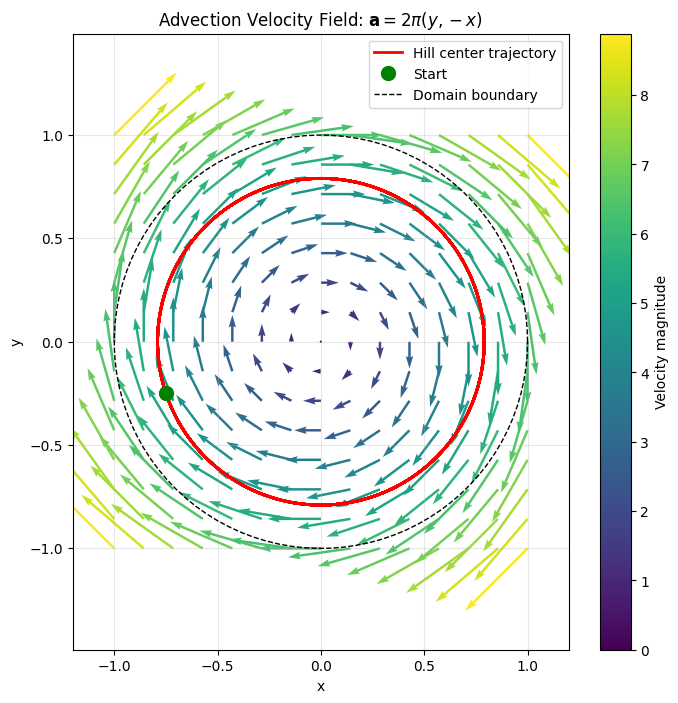

In [4]:
# Plot velocity field on a grid
plt.figure(figsize=(8, 8))

# Create a grid for the velocity field
x_grid = np.linspace(-1, 1, 15)
y_grid = np.linspace(-1, 1, 15)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Get velocity at each grid point
U, V = advection_velocity_field(X_grid, Y_grid)

# Plot velocity field with arrows
plt.quiver(X_grid, Y_grid, U, V, np.sqrt(U**2 + V**2),
           cmap='viridis', scale=50, width=0.005)
plt.colorbar(label='Velocity magnitude')

# Add hill center trajectory
plt.plot(x_center_t, y_center_t, 'r-', linewidth=2, label='Hill center trajectory')
plt.plot(x_center_t[0], y_center_t[0], 'go', markersize=10, label='Start')

# Add unit circle boundary
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Domain boundary')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Advection Velocity Field: $\\mathbf{a} = 2\\pi(y, -x)$')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


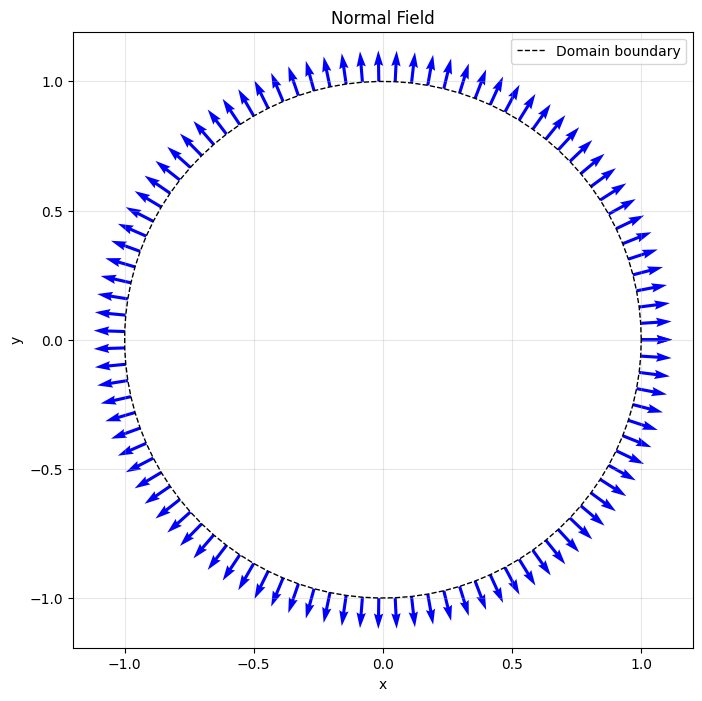

In [5]:
# Plot normal field
plt.figure(figsize=(8, 8))
# Create points on the boundary (unit circle)
theta = np.linspace(0, 2*np.pi, 100)
x_boundary = np.cos(theta)
y_boundary = np.sin(theta)
nx, ny = get_boundary_normal(x_boundary, y_boundary)
plt.quiver(x_boundary, y_boundary, nx, ny, color='blue', scale=20, width=0.005)
plt.plot(x_boundary, y_boundary, 'k--', linewidth=1, label='Domain boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal Field')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Check that normal is unit
assert np.allclose(1.0, np.linalg.norm(np.stack((nx, ny)), axis=0))  # Should be all ones

In [6]:
nx_boundary = nx
ny_boundary = ny
ax_boundary, ay_boundary = advection_velocity_field(x_boundary, y_boundary)

n_boundary = np.stack((nx_boundary, ny_boundary), axis=1)
a_boundary = np.stack((ax_boundary, ay_boundary), axis=1)

a_n_boundary = np.einsum('ij,ij->i', a_boundary, n_boundary)
np.allclose(a_n_boundary, 0)

True

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


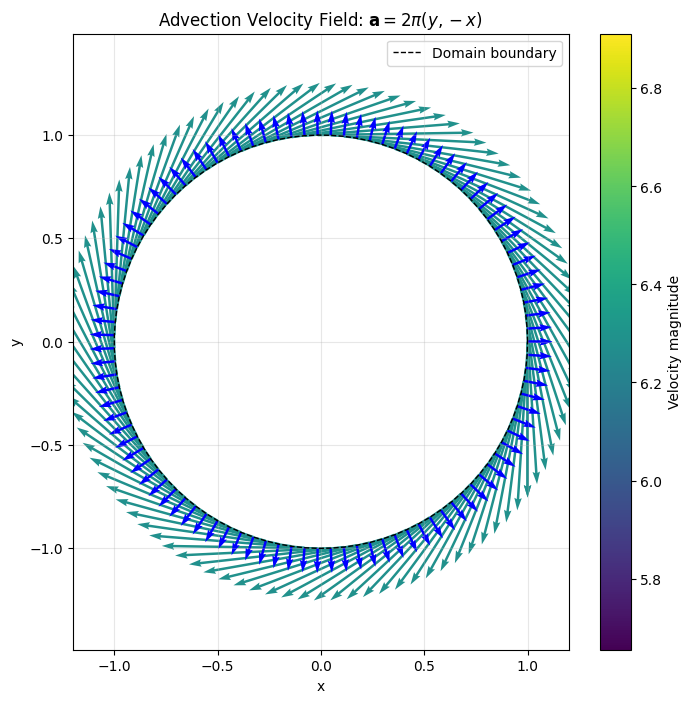

In [7]:
# Plot velocity field on a grid
plt.figure(figsize=(8, 8))

# Get velocity at each grid point
U, V = advection_velocity_field(x_boundary, y_boundary)

# Plot velocity field with arrows
plt.quiver(x_boundary, y_boundary, U, V, np.sqrt(U**2 + V**2),
           cmap='viridis', scale=20, width=0.005)
plt.colorbar(label='Velocity magnitude')
plt.quiver(x_boundary, y_boundary, nx, ny, color='blue', scale=20, width=0.005)

# Add unit circle boundary
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Domain boundary')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Advection Velocity Field: $\\mathbf{a} = 2\\pi(y, -x)$')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### One element

In [8]:
# Problem parameters
N = 20  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Create circle mesh
mesh_2d_circle = create_2d_circle(radius=DOMAIN_RADIUS, origin=DOMAIN_ORIGIN, mesh_size=MESH_SIZE)
K = mesh_2d_circle.num_elements

discretisation_element = create_discretization_element(N=N)
discretisation_mesh = create_discretization_mesh(mesh_2d_circle, discretisation_element)

In [9]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, 1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 20
discretization_element_hill_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global
print(f"{x_global.shape = }")

x_global.shape = (231,)


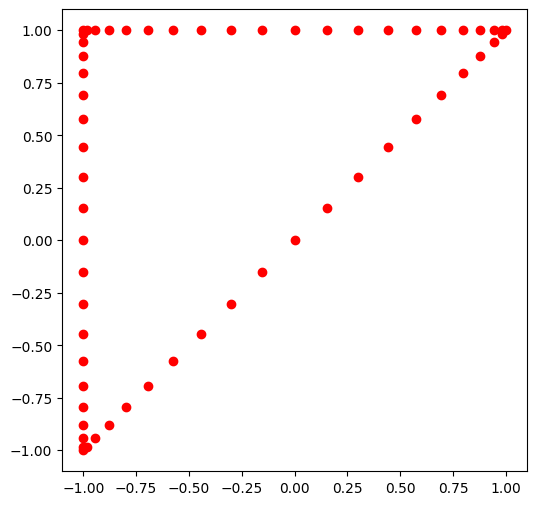

In [10]:
BC_nodes = discretization_mesh_hill_1.BC_nodes
x_boundary = x_global[BC_nodes]
y_boundary = y_global[BC_nodes]
plt.figure(figsize=(6,6))
plt.plot(x_boundary, y_boundary, 'ro', label='Boundary Nodes')

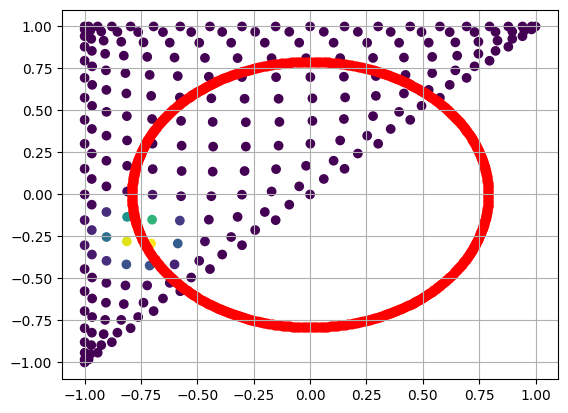

In [11]:
u_true_t = u_exact_hill(x_global, y_global, t=t_array[:, None])
u_0 = u_exact_hill(x_global, y_global, t=0)

plt.scatter(x_global, y_global, c=u_true_t[-1, :], cmap='viridis')
# plt.scatter(x_global, y_global, c=u_0, cmap='viridis')
plt.scatter(x_center_t, y_center_t, color='red')
plt.grid();

In [12]:
class AdvectionIVPSolver2D:
    def __init__(
        self,
        mesh,
        discretization_element,
        discretization_mesh,
        advection_velocity_field,
        g_bc,
        g_bc_dt,
        f_rhs,
    ):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh

        # Advection velocity field, must be stationary
        self.advection_velocity_field = advection_velocity_field

        # These are used for the boundary conditions
        self.g_bc = g_bc  # Boundary Condition u(x,y,t)
        self.g_bc_dt = g_bc_dt  # Time derivative of BC du/dt(x,y,t)

        # This is the source term/RHS without
        self.f_rhs = f_rhs  # Source function f(x,y,t)

        # Pre-allocate global matrices
        self.Chol_M_global = None
        self.Chol_lower = None

        # Assemble constant matrices immediately (since velocity field is stationary)
        self.L_global, self.M_global = self.construct_global_assembly()

        # Apply BCs to get system matrices
        self.M_sys, self.L_sys = self.apply_matrix_bc()

        # Pre-factorize M for efficiency
        self.M_sys_solver = sp.linalg.factorized(self.M_sys.tocsc())

    def construct_L_n_element(self, Dx, Dy, M, x_nodes, y_nodes):
        ax, ay = self.advection_velocity_field(x_nodes, y_nodes)

        # Strong form advection operator on element: M @ (ax*Dx + ay*Dy)
        # Corresponds to (v, a.grad(u))
        return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

    def construct_global_assembly(self) -> tuple[npt.NDArray, npt.NDArray]:
        """
        Implementation of Global Assembly based on FEM Book Algorithms 15 & 16.
        Modified for Advection (Non-Symmetric L).
        """
        print("Assembling global matrices...")

        gidx = self.discretization_mesh.gidx

        # Use sparse matrix construction for efficiency
        # We collect triplets (row, col, value)
        L_rows, L_cols, L_vals = [], [], []
        M_rows, M_cols, M_vals = [], [], []

        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        for n_element in tqdm(range(self.mesh.num_elements)):
            # 1. Get Element Geometry
            # (Assuming get_n_element_operators is available as in your snippet)
            # You might need to pass physical nodes to your operator function if it calculates metrics
            node_indices = C[n_element, :]
            x_nodes = x_global[node_indices]
            y_nodes = y_global[node_indices]

            # Reconstruct vertices for the metric terms if needed by your helper
            # (Assuming your existing helper works as before)
            x_vertex = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex = self.mesh.V_y[self.mesh.EtoV[n_element, :]]
            v1 = np.array([x_vertex[0], y_vertex[0]])
            v2 = np.array([x_vertex[1], y_vertex[1]])
            v3 = np.array([x_vertex[2], y_vertex[2]])

            # Get local operators (Reference Dx, Dy and Metric-scaled M)
            Dx, Dy, M_local, _, _ = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1,
                v2_n=v2,
                v3_n=v3,
            )

            # Construct Local Advection Matrix L (Algorithm 15)
            L_local = self.construct_L_n_element(Dx, Dy, M_local, x_nodes, y_nodes)

            # 3. Add to lists for Sparse Assembly
            # Create meshgrid of indices for this element
            r_idx, c_idx = np.meshgrid(node_indices, node_indices, indexing="ij")

            L_rows.extend(r_idx.flatten())
            L_cols.extend(c_idx.flatten())
            L_vals.extend(L_local.flatten())

            M_rows.extend(r_idx.flatten())
            M_cols.extend(c_idx.flatten())
            M_vals.extend(M_local.flatten())

        # Create Sparse Matrices
        L_global = sp.coo_matrix((L_vals, (L_rows, L_cols)), shape=(gidx, gidx)).tocsr()
        M_global = sp.coo_matrix((M_vals, (M_rows, M_cols)), shape=(gidx, gidx)).tocsr()

        return L_global, M_global

    def apply_matrix_bc(self):
        """
        Modifies M and L to enforce BCs on the system level (Algorithm 17).
        For boundary node i:
          Row i of L_sys becomes 0.
          Row i of M_sys becomes unit row (diagonal=1, others=0).
        Equation becomes: 1 * du_i/dt = RHS_i
        """
        M_sys = self.M_global.copy()
        L_sys = self.L_global.copy()
        bc_nodes = self.discretization_mesh.BC_nodes

        # Zero out rows for boundary nodes
        # Note: We do NOT zero out columns. The interior nodes still need
        # to "feel" the mass/advection from the boundary nodes.
        M_sys[bc_nodes, :] = 0.0
        L_sys[bc_nodes, :] = 0.0

        # Set diagonal of Mass matrix to 1.0 for boundary nodes
        M_sys[bc_nodes, bc_nodes] = 1.0

        return M_sys, L_sys

    def get_rhs_IVP(self, t, u):
        """
        Computes du/dt = M^-1 * (-L*u + f + BC_terms)
        """
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global
        bc_nodes = self.discretization_mesh.BC_nodes

        # Enforce exact BC values on the state vector
        u_full = u.copy()
        u_full[bc_nodes] = self.g_bc(x_global[bc_nodes], y_global[bc_nodes], t)

        # Construct RHS
        # Term 1: - L * u
        rhs = -self.L_sys @ u_full
        # Term 2: + f (source term)
        f_vec = self.f_rhs(x_global, y_global, t)
        rhs += self.M_sys @ f_vec

        # Enforce exact time derivative at BC nodes
        rhs[bc_nodes] = self.g_bc_dt(x_global[bc_nodes], y_global[bc_nodes], t)

        # Solve
        du_dt = self.M_sys_solver(rhs)

        return du_dt

In [13]:
# Problem Functions
def get_hill_center(
    t: float, *, x_0: npt.NDArray, y_0: npt.NDArray
) -> tuple[npt.NDArray, npt.NDArray]:
    omega = 2 * np.pi
    x_t = x_0 * np.cos(omega * t) + y_0 * np.sin(omega * t)
    y_t = -x_0 * np.sin(omega * t) + y_0 * np.cos(omega * t)
    return x_t, y_t


def u_exact_hill(x, y, t, *, sigma):
    x_center_t, y_center_t = get_hill_center(t, x_0=x_0, y_0=y_0)
    return np.exp(-((x - x_center_t) ** 2 + (y - y_center_t) ** 2) / (2 * sigma**2))


def u_exact_hill_dt(x, y, t, *, x_0, y_0, sigma):
    omega = 2 * np.pi
    xc, yc = get_hill_center(t, x_0=x_0, y_0=y_0)
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)


def f_rhs_hill(x: npt.NDArray, y: npt.NDArray, t: float) -> npt.NDArray:
    return np.zeros_like(x)


def advection_velocity_field(x: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
    return (2 * np.pi * y, -2 * np.pi * x)

Total DOFs: 5966
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 522.36it/s]
c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Computing Error...
L2 Error at t=1.0: 2.15e-02


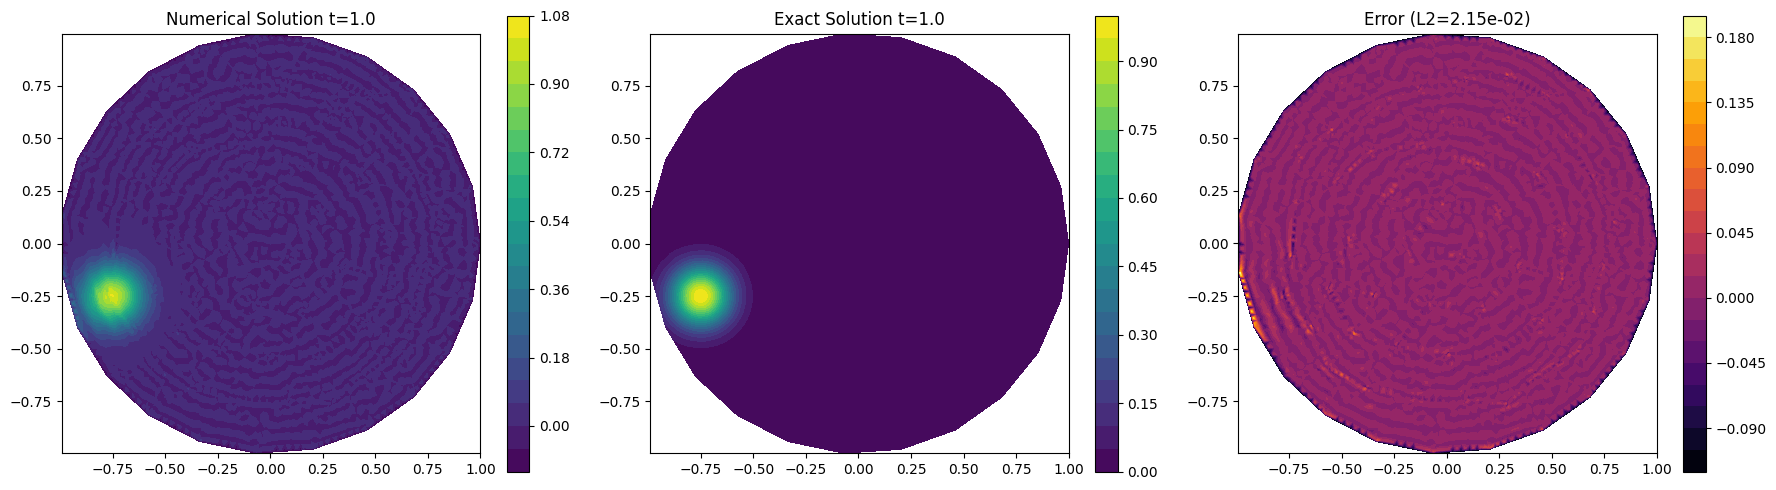

In [14]:
# Solver parameters
N = 10  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.85, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 1.0

mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=50)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")


solver = AdvectionIVPSolver2D(
    mesh=mesh,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
)

# Set up initial condition
u0 = u_exact_hill(
    d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA
)

t_span = (t_start, t_final,)
n_frames = 60
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    rtol=1e-6,  # Relative tolerance
    atol=1e-9,  # Absolute tolerance
)

u_sols, t_sols = sol.y.T, sol.t

# Compute Error
print("Computing Error...")
final_sol = u_sols[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
print(f"L2 Error at t={t_final}: {L2_err:.2e}")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Triangulation for plotting
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

# Solution
tc1 = axs[0].tricontourf(triang, final_sol, levels=20, cmap="viridis")
fig.colorbar(tc1, ax=axs[0])
axs[0].set_title(f"Numerical Solution t={t_final}")
axs[0].set_aspect("equal")

# Exact
tc2 = axs[1].tricontourf(triang, exact_sol, levels=20, cmap="viridis")
fig.colorbar(tc2, ax=axs[1])
axs[1].set_title(f"Exact Solution t={t_final}")
axs[1].set_aspect("equal")

# Error
tc3 = axs[2].tricontourf(triang, error, levels=20, cmap="inferno")
fig.colorbar(tc3, ax=axs[2])
axs[2].set_title(f"Error (L2={L2_err:.2e})")
axs[2].set_aspect("equal")

plt.tight_layout()
# plt.savefig("solution_plot.png")
# print("Plot saved.")


In [16]:
n_frames = 60
t_eval_points = np.linspace(t_start, t_final, n_frames)

print(f"Resolving IVP for animation with {n_frames} frames...")

u_anim = sol.y.T  # Shape: (n_frames, n_dofs)
t_anim = sol.t

# Pre-compute limits for stable colormaps
# Solution limits
u_min, u_max = np.min(u_anim), np.max(u_anim)

# Error limits (We need to compute exact solution for all frames first)
# This prevents the error plot from flashing wildly at t=0 when error is near zero
print("Pre-calculating error bounds...")
all_exact = np.array([u_exact_hill(d_mesh.x_global, d_mesh.y_global, t, sigma=SIGMA) for t in t_anim])
all_error = u_anim - all_exact
err_min, err_max = np.min(all_error), np.max(all_error)
# Center error colormap around 0 for better visualization of over/undershoot
err_abs_max = max(abs(err_min), abs(err_max))

# Setup Plotting Environment
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

def update(frame):
    # Clear previous frame's contours
    for ax in axs:
        ax.clear()
        ax.set_aspect("equal")
        ax.set_xlim(-DOMAIN_RADIUS, DOMAIN_RADIUS)
        ax.set_ylim(-DOMAIN_RADIUS, DOMAIN_RADIUS)

    current_t = t_anim[frame]
    current_u = u_anim[frame]
    current_exact = all_exact[frame]
    current_error = all_error[frame]

    # --- Plot Numerical Solution ---
    # using vmin/vmax locks the color scale so the wave creates contrast against the background
    tc1 = axs[0].tricontourf(triang, current_u, levels=20, cmap="viridis", vmin=u_min, vmax=u_max)
    axs[0].set_title(f"Numerical: t={current_t:.3f}")

    # --- Plot Exact Solution ---
    tc2 = axs[1].tricontourf(triang, current_exact, levels=20, cmap="viridis", vmin=u_min, vmax=u_max)
    axs[1].set_title(f"Exact: t={current_t:.3f}")

    # --- Plot Error ---
    # using 'seismic' or 'coolwarm' is better for error to distinguish positive/negative deviation
    tc3 = axs[2].tricontourf(triang, current_error, levels=20, cmap="seismic", vmin=-err_abs_max, vmax=err_abs_max)
    axs[2].set_title(f"Error (Num - Exact)")

    return axs

# Add Colorbars (Static)
# Solution Colorbar (for plots 1 and 2)
sm_sol = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=u_min, vmax=u_max))
sm_sol.set_array([])
cbar1 = fig.colorbar(sm_sol, ax=axs[:2].ravel().tolist(), shrink=0.9, pad=0.05)
cbar1.set_label("u(x,y)")

# Error Colorbar (for plot 3)
sm_err = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=-err_abs_max, vmax=err_abs_max))
sm_err.set_array([])
cbar2 = fig.colorbar(sm_err, ax=axs[2], shrink=0.9, pad=0.05)
cbar2.set_label("Error")

# Create Animation
anim = animation.FuncAnimation(fig, update, frames=len(t_anim), interval=100)

plt.close() # Prevent static display

# Display
HTML(anim.to_jshtml())
# To save as MP4:
anim.save('advection_sim.mp4', fps=15)

Resolving IVP for animation with 60 frames...
Pre-calculating error bounds...


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

# TODO

- Upwind flux